# 시작하기 전에
LSTM과 GRU는 순환 신경망에서 뺴놓을 수 없는 핵심으로써  
이전에 배운 것들보다 훨씬 복잡하다.  
하지만 높은 성능을 가지기 때문에 널리 사용된다.  


# LSTM 구조
Long Short Term Momory의 약자로 단기 기억을 오래 기억하기 위한 것이다.  
LSTM은 구조가 복잡하므로 단계적으로 설명하는 것이 좋다.  
하지만 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는건  
비슷하며 이런 구조를 여러개 가지고 있다.  
하나하나 따라가 보자  

1. 은닉상태 만들기  
은닉상태는 입력과 이전 타임스탭의 은닉상태 * 가중치, 활성화함수를  
통과시켜서 다음 은닉 상태를 만든다.  
활성화 함수는 시그모이드 함수를 사용한다.  
또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 완성한다.  

2. 셀상태  
은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 LSTM셀에서 순환만 한다.  
셀 상태 계산법은 다음과 같다.  
입력과 은닉상태를 또 다른 가중치에 곱한다음 시그모이드 함수를 통과한다.  
그 다음 이전 타임 스텝의 셀 상태와 곱하여 새로운 셀 상태를 만든다.  
이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉상태를 만드는데 기여한다.  

---

복잡하다.  
LSTM은 마치 작은 셀을 여러 개 포함하고 있는 큰 셀처럼 보인다.  
중요한 것은 입력과 은닉상태에 곱해지는 가중치가 서로 다르다는 것이다.  
아직 끝나지 않았다.  

---

3. 여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는데 기여한다.  
즉 LSTM에는 총 4개의 셀이 있다.  
이전처럼 입력과 은닉을 각기 다른 가중치에 곱하고 하나는 시그모이드  
다른 하나는 tanh 함수를 통과한다.  
이후 그 두 결과를 곱한 후 이전 셀 상태와 더한다.  
이 결과가 최정족인 다음 셀 상태가 된다.  

---

물론 이걸 직접할 필요는 없다.  
케라스에는 이미 LSTM 클래스가 준비되어 있다.  
이걸 사용해보자

# LSTM 신경망 훈련하기

In [2]:
# 데이터 불러오고 훈련세트와 검증세트로 분할
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 [==============================] - 0s 0us/step


이제 각 샘플의 길이를 100에 맞추고 부족하면 패딩을 추가한다.  

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen= 100)
val_seq = pad_sequences(val_input, maxlen= 100)

이제 LSTM을 사용한 순환층을 만든다.

In [4]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

모델의 구조를 출력해보자

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


전에 했던 SimpleRNN 모델의 파라미터는 200개 였다.  
그러나 LSTM에선 작은 셀이 4개 있으므로 4배가 늘어 800개가 되었다.  
모델을 컴파일 하고 훈련해보자  
이전과 마찬가지로 배치 크기는 64개, 에포크 횟수는 100이다.  
체크포인트와 조기종료 또한 동일하다.

In [6]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer = rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights= True)
history = model.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 26s 67ms/step - loss: 0.6928 - accuracy: 0.5253 - val_loss: 0.6924 - val_accuracy: 0.5510
Epoch 2/100
313/313 [==============================] - 18s 57ms/step - loss: 0.6916 - accuracy: 0.5743 - val_loss: 0.6910 - val_accuracy: 0.5742
Epoch 3/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6879 - accuracy: 0.6062 - val_loss: 0.6837 - val_accuracy: 0.5942
Epoch 4/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6618 - accuracy: 0.6668 - val_loss: 0.6443 - val_accuracy: 0.6888
Epoch 5/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6288 - accuracy: 0.7096 - val_loss: 0.6219 - val_accuracy: 0.7126
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6050 - accuracy: 0.7287 - val_loss: 0.6018 - val_accuracy: 0.7288
Epoch 7/100
313/313 [==============================] - 16s 50ms/step - loss: 0.5820 - accuracy: 0.7461 - val_loss: 0.5785 - val_ac

훈련 손실과 검증 손실 그래프를 그려보자

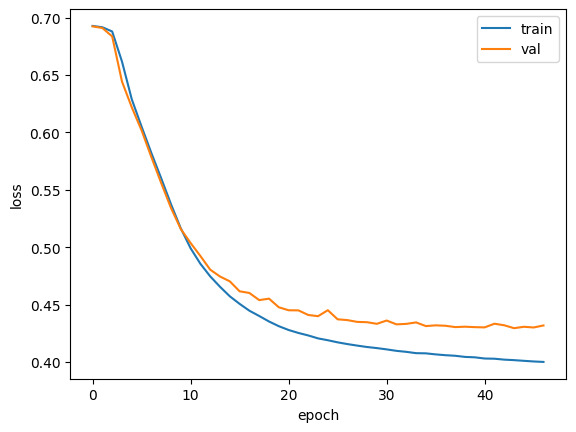

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련을 잘 수행했다.  
다만 과대적합을 더 강하게 제어할 수 없을까?  
드롭아웃을 적용시켜보자.  

# 순환층에 드롭아웃 적용하기
순환층은 자체적으로 드롭아웃 기능을 제공한다.  
전체적인 모델 구조는 이전과 같다.

In [8]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length = 100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

이 모델을 이전과 같은 조건으로 훈련해보자

In [9]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights= True)
history = model2.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 19s 52ms/step - loss: 0.6929 - accuracy: 0.5177 - val_loss: 0.6925 - val_accuracy: 0.5340
Epoch 2/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6916 - accuracy: 0.5666 - val_loss: 0.6911 - val_accuracy: 0.5810
Epoch 3/100
313/313 [==============================] - 16s 50ms/step - loss: 0.6894 - accuracy: 0.6070 - val_loss: 0.6881 - val_accuracy: 0.6238
Epoch 4/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6848 - accuracy: 0.6284 - val_loss: 0.6814 - val_accuracy: 0.6536
Epoch 5/100
313/313 [==============================] - 16s 50ms/step - loss: 0.6727 - accuracy: 0.6596 - val_loss: 0.6618 - val_accuracy: 0.6796
Epoch 6/100
313/313 [==============================] - 16s 50ms/step - loss: 0.6349 - accuracy: 0.7002 - val_loss: 0.6086 - val_accuracy: 0.7192
Epoch 7/100
313/313 [==============================] - 16s 51ms/step - loss: 0.5960 - accuracy: 0.7162 - val_loss: 0.5861 - val_ac

검증 손실이 약간 향상되었다.  
훈련 손실과 검증 손실 그래프를 그려보자

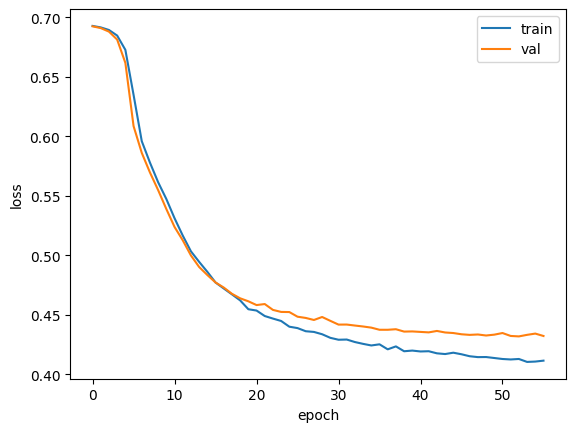

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련손실과 검증손실간의 차이가 좁혀졌다.

# 2개의 층을 연결하기
순환층의 은닉상태는 샘플의 마지막 타임스템에 대한 은닉상태만 다음층으로 전달한다.  
하지만 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요하다.  
따라서 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 한다.  
오직 마지막 순환층만 마지막 타임스텝의 은닉상태를 출력해야 한다.  

In [11]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length = 100))
model3.add(keras.layers.LSTM(8, dropout = 0.3, return_sequences = True))
model3.add(keras.layers.LSTM(8, dropout = 0.3))
model3.add(keras.layers.Dense(1, activation = 'sigmoid'))

2개의 LSTM층을 쌓고 모두 드롭아웃을 0.3으로 지정했다.  
그리고 첫 번째 LSTM 클래스에는 return_sequences 매개변수를 True로 지정했다.   
결과를 확인해보자

In [12]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


첫 번째 LSTM 층은 모든 타임스텝(100개)를 출력한다.  
두 번째 LSTM 층은 마지막 타임스텝의 은닉상태만 출력하여 8이다.  
이 모델을 훈련해보자

In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer = rmsprop, loss='binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history= model3.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 37s 100ms/step - loss: 0.6930 - accuracy: 0.5156 - val_loss: 0.6928 - val_accuracy: 0.5264
Epoch 2/100
313/313 [==============================] - 28s 91ms/step - loss: 0.6922 - accuracy: 0.5571 - val_loss: 0.6913 - val_accuracy: 0.5984
Epoch 3/100
313/313 [==============================] - 31s 98ms/step - loss: 0.6885 - accuracy: 0.6133 - val_loss: 0.6836 - val_accuracy: 0.6512
Epoch 4/100
313/313 [==============================] - 30s 95ms/step - loss: 0.6677 - accuracy: 0.6560 - val_loss: 0.6404 - val_accuracy: 0.6808
Epoch 5/100
313/313 [==============================] - 29s 91ms/step - loss: 0.6009 - accuracy: 0.7026 - val_loss: 0.5735 - val_accuracy: 0.7116
Epoch 6/100
313/313 [==============================] - 28s 91ms/step - loss: 0.5589 - accuracy: 0.7285 - val_loss: 0.5484 - val_accuracy: 0.7312
Epoch 7/100
313/313 [==============================] - 31s 98ms/step - loss: 0.5363 - accuracy: 0.7434 - val_loss: 0.5251 - val_a

잘 훈련된거 같다.
그래프를 그려서 확인 해보자

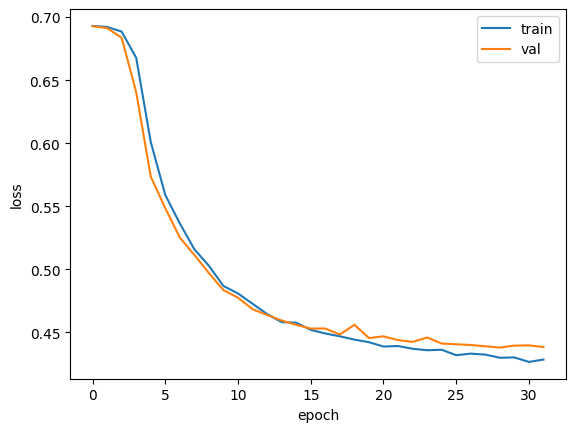

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# GRU 구조
Gated Recurrent Unit의 약자로 LSTM을 간소화 시킨 거라 할 수 있다.  
LSTM 처럼 셀 상태를 계산하지 않고 은닉상태 하나만 포함한다.  
GRU셀은 LSTM보다 가중치가 적어 계산량이 적지만 LSTM 못지않은 좋은 성능을  
가지는 것으로 알려져있다.  


# GRU 신경망 훈련하기

In [15]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

이 모델의 구조를 확인해 보자

In [16]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


GRU셀에는 3개의 작은 셀이 있다.  
작은 셀에는 입력과 은닉 상태에 곱하는 가중치와 절편이 있다.  
입력에 곱하는 가중치는 16 * 8 = 128개다.  
절편은 뉴런마다 하나씩이므로 8개다.  
모두 더하면 128 + 64 + 8 = 200개다.  
이런 작은 셀이 3개이므로 모두 600개가 필요하다.  
그런데 표시된건 624개다.  
어디가 잘못되었을까?  
사실 작은 셀마다 절편이 하나씩 추가되고 8개의 뉴런이 있으므로  
총 24개의 모델 파라미터가 더해진다.  
때문에 모델 파라미터 개수는 총 624개가 된다.  

GRU셀을 사용한 순환 신경망을 훈련해보자

In [18]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model4.compile(optimizer = rmsprop, loss ='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs = 100, batch_size= 64, validation_data = (val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 20s 57ms/step - loss: 0.6923 - accuracy: 0.5247 - val_loss: 0.6912 - val_accuracy: 0.5448
Epoch 2/100
313/313 [==============================] - 22s 72ms/step - loss: 0.6898 - accuracy: 0.5634 - val_loss: 0.6886 - val_accuracy: 0.5790
Epoch 3/100
313/313 [==============================] - 29s 91ms/step - loss: 0.6861 - accuracy: 0.5892 - val_loss: 0.6847 - val_accuracy: 0.5928
Epoch 4/100
313/313 [==============================] - 23s 74ms/step - loss: 0.6806 - accuracy: 0.6076 - val_loss: 0.6783 - val_accuracy: 0.6088
Epoch 5/100
313/313 [==============================] - 18s 57ms/step - loss: 0.6720 - accuracy: 0.6230 - val_loss: 0.6689 - val_accuracy: 0.6240
Epoch 6/100
313/313 [==============================] - 19s 61ms/step - loss: 0.6581 - accuracy: 0.6423 - val_loss: 0.6521 - val_accuracy: 0.6426
Epoch 7/100
313/313 [==============================] - 19s 62ms/step - loss: 0.6333 - accuracy: 0.6651 - val_loss: 0.6198 - val_ac

LSTM과 거의 비슷한 성능을 낸다.  
이 모델의 손실 그래프를 그려보자

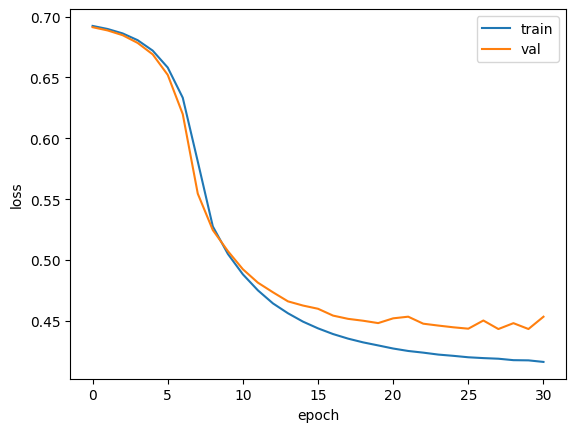

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련과정이 얼추 잘 수렴되고 있다.  

# LSTM과 GRU 셀로 훈련
이제 가장 좋았던 2개의 순환층을 쌓은 모델을 다시 로드해서 테스트 세트에 대한 성능을 확인해 보자  

In [20]:
test_seq = pad_sequences (test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 14s 17ms/step - loss: 0.4331 - accuracy: 0.7979


[0.43311676383018494, 0.7978799939155579]

이 모델은 드롭아웃을 적용하여 과대적합을 잘 억제했기 때문에  
테스트 세트의 성능이 검증 세트와 크게 차이나지 않는다.  